# Goals
- [x] Get ebird data from Alex
    - [x] US only (18g Feb17)
    - [-] [defer] Update US data (18g Feb17 -> 20g May18) so it isn't a truncated gz
    - [-] [defer] Try on global data (18g -> 29g -- turns out checklists are dominated by US)
- [x] ebird.predict_proba(loc, date) -> probs
    - [x] Figure out how to aggregate to make data fit comfortably in mem
    - [x] Make an out-of-core ddf pass over the cols-for-time-space-priors.tsv file to produce the aggregates
    - [x] Use the aggregates in memory to power the priors model
- [ ] Ensemble audio probs + ebird probs (expose tuning param for weighted combination)
- [ ] See how it improves model validation (e.g. many species should be way closer to few species)

In [ ]:
# Global params
ebd = 'ebd_US_relFeb-2017'

In [ ]:
from notebooks import *

# Register a global dask progress bar
dask_progress().register()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# Downsample raw data (in shell)
#   - TODO Downsample by checklist_id instead of line (one species within a checklist) to keep checklist (sampling
#     events) complete, else output priors are junk except for sample=1. This is nontrivial because we have to push the
#     full data volume through far enough to get checklist_id=coalesce(sampling_event_identifier, group_identifier)...
# (
#   set -eux
#   set -o pipefail
#   echo '
#     # 1               #  148m lines
#     # 1     .1 0.1    # 14.8m lines
#     # 0.1   .4 0.04   # 5.91m lines
#     # 0.04  .5 0.02   # 2.96m lines
#     # 0.1   .1 0.01   # 1.48m lines
#     # 0.01  .4 0.004  #  591k lines
#     # 0.004 .5 0.002  #  296k lines
#     # 0.01  .1 0.001  #  148k lines
#     # 0.001 .1 0.0001 #   15k lines
#   ' | while read in_suf sample_frac out_suf comment; do
#     if [ -z "$in_suf" -o "$in_suf" = '#' ]; then continue; fi
#     raw_f='ebd_US_relFeb-2017.txt.gz'
#     in_f="$raw_f-$in_suf"; out_f="$raw_f-$out_suf"
#     cat "$in_f" \
#       | pv -terb -s"`du -Lhs "$in_f" | field 0`" -cN in \
#       | gunzip \
#       | sample-lines "$sample_frac" --seed=0 --keep-header \
#       | pigz \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# Inspect raw data
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz'         #  18gb,  148m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.1'     # 778mb, 14.8m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.01'    # 100mb, 1.48m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.001'   #  12mb,  148k lines
ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.0001'  # 1.3mb,   15k lines
proj_cols = [
    'CATEGORY', 'SCIENTIFIC NAME', 'OBSERVATION COUNT', 'COUNTY CODE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
    'SAMPLING EVENT IDENTIFIER', 'ALL SPECIES REPORTED',
]
ebd_tsv_df = pd.read_csv(ebd_tsv_path, sep='\t', nrows=10000, compression='gzip')
display(
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df))),
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df[proj_cols]))),
    # df_summary(ebd_tsv_df).T,
    df_summary(ebd_tsv_df[proj_cols]).T,
)

[skip]

In [ ]:
# Convert ebd.txt -> proj.tsv (in shell)
#   - ~10x faster to read than raw data: no gunzip + fewer cols
# (
#   set -eux
#   set -o pipefail
#   sufs=(
#     # 0.0001
#     # 0.001
#     # 0.002
#     # 0.004
#     # 0.01
#     # 0.02
#     # 0.04
#     # 0.1
#     # 1
#   )
#   for suf in "${sufs[@]}"; do
#     in_f="ebd_US_relFeb-2017.txt.gz-$suf"
#     out_f="derived/priors/ebd_US_relFeb-2017-1-proj.tsv-$suf"
#     cat "$in_f" \
#       | pv -terb -cN in -s"`du -Ls "$in_f" | field 0`K" \
#       | gunzip \
#       | cut -f4,6,9,17,25,26,27,32,39,40 \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# FIXME ebd_US_relFeb-2017.txt.gz looks truncated (maybe the original download didn't complete?)
#
#   # Convert ebd.txt -> proj.tsv (in shell)
#   $ ...
#   + in_f=ebd_US_relFeb-2017.txt.gz-1
#   + out_f=derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   ...
#         out: 11.6GiB 0:13:21 [11.3MiB/s]
#         out: 11.6GiB 0:13:21 [14.9MiB/s]
#   gunzip: (stdin): unexpected end of file
#
#   $ tail -3 derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   species Regulus calendula       2       US-OR-067       45.546725       -122.9678249    2012-03-07      S10112003       1
#   species Recurvirostra americana 13      US-UT-053       37.1810055      -113.7148046    2012-03-18      S10208648       0
#   species Passer domesticus       5       US-WI-097       44.4993598      -89.5568454     2012-01-19      S96324

# Tuning notes
- TODO Pick lightweight tuning params to get started
- Query radius ~ binwidth, since query region is a rect with sides binwidth*2, approximately centered at the query point

In [ ]:

from ebird_priors import *
from potoo.pandas import df_style_cell
loc_bin_slice = slice(3, None)
# loc_bin_slice = slice(0, None)
loc_binwidths = np.array(list(EbirdPriors._loc_binwidths.keys()))[loc_bin_slice]
loc_bin_ns = 2 ** np.array(list(EbirdPriors._loc_binwidths.values()))[loc_bin_slice]
date_binwidths = [x for x in EbirdPriors._date_binwidths]
date_bin_ns = 48 // np.array([EbirdPriors._date_binwidth_parse_weeks(x) for x in EbirdPriors._date_binwidths])
(DF(columns=date_binwidths, index=loc_binwidths, data=np.vectorize(humanize.naturalsize)(
    400 * np.array(loc_bin_ns)[:, np.newaxis] * np.array(date_bin_ns)
)).T
    .style.applymap(lambda x: df_style_cell(
        (lambda x: x[-1] in ['Bytes', 'kB'],       'color: #1f78b4'),  # dark blue
        (lambda x: x[-1] in ['MB'] and x[0] < 10,  'color: #a6cee3'),  # blue/green
        (lambda x: x[-1] in ['MB'] and x[0] < 100, 'color: #33a02c'),  # green
        (lambda x: x[-1] in ['MB'],                'color: #ffff99'),  # yellow
        (lambda x: x[-1] in ['GB'] and x[0] < 10,  'color: #ff7f00'),  # orange
        (lambda x: x[-1] in ['GB'] and x[0] < 100, 'color: #fb9a99'),  # orange/red/pink
        (lambda x: x[-1] in ['GB'],                'color: #e31a1c'),  # dark red
        (lambda x: x[-1] in ['TB'],                'color: #6a3d9a'),  # dark purple
    )(one((float(a), b) for a, b in [x.split()])))
)

,1551mi,775mi,388mi,194mi,97mi,48mi,24mi,12mi,6mi,3mi,1.5mi,.8mi,.4mi
48w,51.2 kB,204.8 kB,819.2 kB,3.3 MB,13.1 MB,52.4 MB,209.7 MB,838.9 MB,3.4 GB,13.4 GB,53.7 GB,214.7 GB,859.0 GB
24w,102.4 kB,409.6 kB,1.6 MB,6.6 MB,26.2 MB,104.9 MB,419.4 MB,1.7 GB,6.7 GB,26.8 GB,107.4 GB,429.5 GB,1.7 TB
16w,153.6 kB,614.4 kB,2.5 MB,9.8 MB,39.3 MB,157.3 MB,629.1 MB,2.5 GB,10.1 GB,40.3 GB,161.1 GB,644.2 GB,2.6 TB
12w,204.8 kB,819.2 kB,3.3 MB,13.1 MB,52.4 MB,209.7 MB,838.9 MB,3.4 GB,13.4 GB,53.7 GB,214.7 GB,859.0 GB,3.4 TB
8w,307.2 kB,1.2 MB,4.9 MB,19.7 MB,78.6 MB,314.6 MB,1.3 GB,5.0 GB,20.1 GB,80.5 GB,322.1 GB,1.3 TB,5.2 TB
6w,409.6 kB,1.6 MB,6.6 MB,26.2 MB,104.9 MB,419.4 MB,1.7 GB,6.7 GB,26.8 GB,107.4 GB,429.5 GB,1.7 TB,6.9 TB
4w,614.4 kB,2.5 MB,9.8 MB,39.3 MB,157.3 MB,629.1 MB,2.5 GB,10.1 GB,40.3 GB,161.1 GB,644.2 GB,2.6 TB,10.3 TB
3w,819.2 kB,3.3 MB,13.1 MB,52.4 MB,209.7 MB,838.9 MB,3.4 GB,13.4 GB,53.7 GB,214.7 GB,859.0 GB,3.4 TB,13.7 TB
2w,1.2 MB,4.9 MB,19.7 MB,78.6 MB,314.6 MB,1.3 GB,5.0 GB,20.1 GB,80.5 GB,322.1 GB,1.3 TB,5.2 TB,20.6 TB
1w,2.5 MB,9.8 MB,39.3 MB,157.3 MB,629.1 MB,2.5 GB,10.1 GB,40.3 GB,161.1 GB,644.2 GB,2.6 TB,10.3 TB,41.2 TB


In [ ]:
# (mem, time) ~ query radius: "theoretical[empirical]"
#   - sample=1: ~23m floor just to do the map-side processing from .tsv to set_index (before map_partitions or final groupby)
#   - TODO Measure a few points to sketch out the surface
#        48mi                   24mi                   12mi                     6mi                     3mi                    1.5mi
#   48w   52m                   209m                   838m                    3.4g                     13g                      53g
#   24w  104m                   419m                   1.7g                    6.7g                     26g                     107g
#   16w  157m                   629m                   2.5g                     10g                     40g                     161g
#   12w  209m                   838m                   3.4g                     13g                     53g                     214g
#   8w   314m                   1.3g[ g39k,26m,2147s]  5.0g                     20g                     80g                     322g
#   6w   419m[g16k,11m,<2107s]  1.7g[ g50k,32m,2207s]  6.7g                     26g                    107g                     429g
#   4w   629m                   2.5g[ g69k,41m,2297s]   10g[g168k,56m,<4673s]   40g[g332k,125m,5751s]  161g[g555k,181m,13111s]  644g
#   3w   838m                   3.4g[ g87k,49m,2411s]   13g                     53g                    214g                     859g
#   2w   1.3g                   5.0g[g120k,64m,2575s]   20g                     80g                    322g                     1.3t
#   1w   2.5g                    10g[g203k,99m,2988s]   40g                    161g                    644g                     2.6t

In [ ]:
# Q: How much cpu/mem does it take to load the models from pkl?
#   A: (See table)
ebird_priors = None
with print_mem_delta(collect_before=True, collect_after=True):
    ebird_priors = EbirdPriors.load(
        # '3mi',     '4w',  1,      ebd,  # pkl[g555k,181mb], load[ 66s,1.3gb]
        # '6mi',     '4w',  1,      ebd,  # pkl[g332k,125mb], load[ 45s,798mb]
        # '12mi',    '4w',  1,      ebd,  # pkl[g168k, 56mb], load[ 25s,437mb]
        # '24mi',    '1w',  1,      ebd,  # pkl[g203k, 99mb], load[ 41s,612mb]
        # '24mi',    '2w',  1,      ebd,  # pkl[g120k, 64mb], load[ 23s,377mb]
        # '24mi',    '3w',  1,      ebd,  # pkl[ g87k, 49mb], load[ 18s,149mb]
        # '24mi',    '4w',  1,      ebd,  # pkl[ g69k, 41mb], load[ 15s, 83mb]
        # '24mi',    '6w',  1,      ebd,  # pkl[ g50k, 32mb], load[ 12s, 59mb]
        # '24mi',    '8w',  1,      ebd,  # pkl[ g39k, 26mb], load[9.7s, 21mb]
        # '48mi',    '6w',  1,      ebd,  # pkl[ g16k, 11mb], load[5.1s, 24mb]
        '12407mi', '48w', 0.0001, ebd,  # pkl[   g2,   8k], load[  0s,  0b]
    )

[skip]

In [ ]:
# Q: Is it fast (enough) to query the bigger models?
#   A: Yep! ~O(1) in practice (in theory: O(8 queries * max(len(counts_[k]))))
models = {}
for params in [
    ('12407mi', '48w', 1,      ebd),  # pkl[   g2], load[  0s], query[6ms]
    (   '48mi',  '6w', 1,      ebd),  # pkl[ g16k], load[4.4s], query[6ms]
    (   '24mi',  '8w', 1,      ebd),  # pkl[ g39k], load[8.3s], query[5ms]
    (   '24mi',  '6w', 1,      ebd),  # pkl[ g50k], load[ 10s], query[6ms]
    (   '24mi',  '4w', 1,      ebd),  # pkl[ g69k], load[ 13s], query[6ms]
    (   '24mi',  '3w', 1,      ebd),  # pkl[ g87k], load[ 16s], query[6ms]
    (   '24mi',  '2w', 1,      ebd),  # pkl[g120k], load[ 21s], query[6ms]
    (   '24mi',  '1w', 1,      ebd),  # pkl[g203k], load[ 41s], query[6ms]
    (   '12mi',  '4w', 1,      ebd),  # pkl[g168k], load[ 24s], query[5ms]
    (    '6mi',  '4w', 1,      ebd),  # pkl[g332k], load[ 42s], query[6ms]
    (    '3mi',  '4w', 1,      ebd),  # pkl[g555k], load[ 63s], query[5ms]
]:
    with print_time_delta('load'):
        ebird_priors = EbirdPriors.load(*params)
    models[params] = ebird_priors
    lat, lon = 37.9, -122  # Mt. Diablo
    date = datetime.date(2000, 5, 1)
    with print_time_delta('query'):
        df = ebird_priors.predict_one_df(lat, lon, date)
    print(params)
    pp(df
        .sort_values('p')[-10:]
        .sort_values('species').reset_index(drop=True)
        .merge(metadata.species.df[['shorthand', 'longhand']], how='left', left_on='species', right_on='shorthand')
        .drop(columns=['species', 'shorthand']).pipe(df_reorder_cols, first=['longhand'])
    )
    print()

[skip]

In [ ]:
# lat, lon = 37.9, -122  # Mt. Diablo
lat, lon = 37.75, -122.45  # SF (Twin Peaks)
date = datetime.date(2000, 9, 1)
pd.concat(axis=1, objs=(
    (models[params].predict_one_df(lat, lon, date)
        .sort_values('p', ascending=False)[:70].reset_index(drop=True)
        .sort_values('species').reset_index(drop=True)
        .merge(metadata.species.df[['shorthand', 'com_name']], how='left', left_on='species', right_on='shorthand')
        .assign(c=lambda df: df.apply(axis=1, func=lambda row: (
            '%s %s' % (row.com_name, ebird_bar_str(row.p))
        )))
        [['c']]
        .rename(columns={'c': ','.join(params[:2])})
    )
    for i, params in enumerate([

        # Over date_binwidth
        (   '24mi',  '8w', 1,      ebd),
        (   '24mi',  '6w', 1,      ebd),
        (   '24mi',  '4w', 1,      ebd),
        (   '24mi',  '3w', 1,      ebd),
        (   '24mi',  '2w', 1,      ebd),
        (   '24mi',  '1w', 1,      ebd),

        # # Over loc_binwidth
        # ('12407mi', '48w', 1,      ebd),  # Fudge
        # (   '48mi',  '6w', 1,      ebd),  # Fudge
        # (   '24mi',  '4w', 1,      ebd),
        # (   '12mi',  '4w', 1,      ebd),
        # (    '6mi',  '4w', 1,      ebd),
        # (    '3mi',  '4w', 1,      ebd),

    ])
))

[skip]

In [ ]:
# %%snakeviz
# %%prun -l50 -scumtime
for params in [

    ('12407mi', '48w', 0.0001,  ),  # groups[   2], t_par[  3.3s], pkl[  8k]
    # ('12407mi', '48w', 0.001,   ),  # groups[   2], t_par[  3.0s], pkl[ 11k]
    # ('12407mi', '48w', 0.01,    ),  # groups[   2], t_par[   19s], pkl[ 14k]
    # ('12407mi', '48w', 0.1,     ),  # groups[   2], t_par[  207s], pkl[ 17k]
    # ('12407mi', '48w', 1,       ),  # groups[   2], t_par[ 1414s], pkl[ 17k]
    # (   '97mi',  '6w', 0.0001,  ),  # groups[2.0k], t_par[<  13s], pkl[252k]
    # (   '97mi',  '6w', 0.001,   ),  # groups[3.4k], t_par[<  25s], pkl[640k]
    # (   '97mi',  '6w', 0.01,    ),  # groups[4.2k], t_par[<  59s], pkl[1.5m]
    # (   '48mi', '48w', 0.0001,  ),  # groups[1.1k], t_par[< 9.1s], pkl[164k]
    # (   '48mi', '24w', 0.0001,  ),  # groups[1.8k], t_par[<  12s], pkl[228k]
    # (   '48mi', '12w', 0.0001,  ),  # groups[2.6k], t_par[<  16s], pkl[308k]
    # (   '48mi',  '6w', 0.0001,  ),  # groups[3.6k], t_par[<  20s], pkl[408k]
    # (   '48mi',  '6w', 0.001,   ),  # groups[8.7k], t_par[   30s], pkl[1.2m]
    # (   '48mi',  '6w', 0.01,    ),  # groups[ 13k], t_par[< 113s], pkl[3.0m]
    # (   '48mi',  '6w', 1,       ),  # groups[ 16k], t_par[<2107s], pkl[ 11m]
    # TODO What does the acc curve look like as date_binwidth varies? How wide/cheap can we get away with?
    # (   '24mi',  '8w', 1,       ),  # groups[ 39k], t_par[ 2147s], pkl[ 26m]
    # (   '24mi',  '6w', 1,       ),  # groups[ 50k], t_par[ 2207s], pkl[ 32m]
    # (   '24mi',  '4w', 1,       ),  # groups[ 69k], t_par[ 2297s], pkl[ 41m]
    # (   '24mi',  '3w', 1,       ),  # groups[ 87k], t_par[ 2411s], pkl[ 49m]
    # (   '24mi',  '2w', 1,       ),  # groups[120k], t_par[ 2575s], pkl[ 64m]
    # (   '24mi',  '1w', 1,       ),  # groups[203k], t_par[ 2988s], pkl[ 99m]
    # (   '12mi',  '4w', 1,       ),  # groups[168k], t_par[<4673s], pkl[ 56m] GOOOOOL! -- run some evals!
    # TODO What does the acc curve look like as loc_binwidth varies? How narrow do we need to push? (Probably varies by geo anyway...)
    # (   '48mi',  '4w', 1,       ),  # groups[TODO], t_par[  TODO], pkl[TODO] -- extend out by another point (including 24mi above)
    # (    '6mi',  '4w', 1,       ),  # groups[332k], t_par[ 5751s], pkl[125m]
    # (    '3mi',  '4w', 1,       ),  # groups[555k], t_par[13111s], pkl[181m] -- ~900m pkl / mem pressure
    # (  '1.5mi',  '4w', 1,       ),  # groups[TODO], t_par[  TODO], pkl[TODO] -- WARNING ~3.5g pkl / mem pressure

]:
    (loc_binwidth, date_binwidth, sample) = params
    ebird_priors = EbirdPriors(loc_binwidth=loc_binwidth, date_binwidth=date_binwidth)
    paths = ebird_priors.paths(sample=sample, ebd=ebd)
    timer = timer_start()

    # Perf tuning params (no change in output data)
    ebd_proj_size        = 12 * 1024**3
    ebd_proj_npartitions = 128

    # Old notes from perf tuning, somewhat duplicated below
    #   - TODO Clean up so we can delete one copy
    #
    # (1/3) Compute priors[loc_bin, date_bin, sci_name, n_present, n] <- priors[sci_name, loc, date]
    #   - (loc_bin, date_bin): cheap map-side operations
    #   - n_present: mid-weight groupby agg
    #   - n: heavy windowed agg [overall bottleneck, super-linear]
    # sample = 1      #  148m lines,  18gb input, no_chk[?],    chk[1512  + 3713s]  # TODO Regen data [+ perf stats per new params]
    # sample = 0.1    # 14.8m lines, 778mb input, no_chk[?],    chk[ 153  +   87s]  # TODO Regen data [+ perf stats per new params]
    # sample = 0.04   # 5.91m lines, 350mb input, no_chk[?],    chk[  55  +   13s]
    # sample = 0.02   # 2.96m lines, 189mb input, no_chk[?],    chk[  28  +    7.5s]
    # sample = 0.01   # 1.48m lines, 100mb input, no_chk[19s],  chk[  14  +    3.8s]
    # sample = 0.004  #  591k lines,  43mb input, no_chk[?],    chk[  5.6 +    1.8s]
    # sample = 0.002  #  296k lines,  23mb input, no_chk[?],    chk[  2.9 +    1.1s]
    # sample = 0.001  #  148k lines,  12mb input, no_chk[2.1s], chk[  1.6 +    0.8s]
    # sample = 0.0001 #   15k lines,   1mb input, no_chk[?],    chk[?]
    #
    # (2/3) Convert priors_ddf.parquet -> priors_df.parquet
    # sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  18s total, 205mb out
    # sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet, 4.2s total,  64mb out
    # sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.0s total,  12mb out
    # sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet,  <1s total, 1.7mb out
    #
    # (3/3) Compute priors[ix:loc_bin, ix:date_bin, species, n_present, n] <- priors[loc_bin, date_bin, sci_name, n_present, n]
    # sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  37s total
    # sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet,  11s total
    # sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.7s total
    # sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet, .30s total
    #
    # ddf tuning resources:
    #   - http://dask.pydata.org/en/latest/dataframe-api.html
    #   - http://dask.pydata.org/en/latest/dataframe-performance.html
    #   - http://dask.pydata.org/en/latest/dataframe.html
    #   - http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.set_index

    _counts_df = (

        # Read proj.tsv (raw lines with subset of cols)
        #   - sample=0.001: 148k rows, 12mb
        dd.read_csv(
            paths.ebd_proj_tsv,
            # TODO Tune partitions
            # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample),
            # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 10),
            # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 100),
            blocksize=int(ebd_proj_size / ebd_proj_npartitions / 10),  # TODO This seems to work ok...?
            sep='\t',
            dtype={
                # lonlat decimal precision [https://en.wikipedia.org/wiki/Decimal_degrees]
                #   - float32: ~5-6 decimals, ~.1-1m
                #   - float16: ~1-2 decimals, ~1-10km
                'LATITUDE': 'float32',
                'LONGITUDE': 'float32',
                'OBSERVATION COUNT': 'str',  # int | 'X'
                'ALL SPECIES REPORTED': 'float16',  # Smallest dtype for {1, 0, None}
            },
        )
        # .pipe(puts, lambda ddf: 'len[%s]: read_csv' % len(ddf))  # Debug

        # Inspect [high-level perf debugging]
        .pipe(df_inspect, f'[read: {paths.ebd_proj_tsv}]', lambda ddf: (
            # f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
            # ddf.reset_index().dtypes.to_frame().T,
            # # Heavy [high-level perf debugging]
            # # '  [memory_usage by partition]',
            # # (ddf
            # #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
            # #     .compute()
            # #     .pipe(df_with_totals).reset_index()[:50]
            # #     # TODO Add a dtype col to the memory_usage outputs
            # #     # .pipe(lambda df: pd.concat(axis=1, objs=[
            # #     #     df,
            # #     #     ddf.reset_index().dtypes.to_frame().rename({'index': 'Index'}),  # TODO Make this not reorder the index
            # #     # ]))
            # # ),
        ))

        # Simplify col names
        .rename(columns=lambda c: c.lower().replace(' ', '_'))

        # Drop cols we don't need
        .drop(axis=1, labels=['county_code'])

        # Keep obs with well defined species [https://help.ebird.org/customer/portal/articles/1006825]
        #   - sample=0.001: 144k rows
        .pipe(lambda ddf: ddf[ddf.category.isin(['species', 'domestic', 'issf', 'form'])])
        .drop(axis=1, labels=['category'])
        # .pipe(puts, lambda ddf: 'len[%s]: categories.isin' % len(ddf))  # Debug

        # Keep obs from checklists that represent a complete sampling of all present species
        #   - sample=0.001: 125k rows
        .pipe(lambda ddf: ddf[ddf.all_species_reported == 1])
        .drop(axis=1, labels=['all_species_reported'])
        # .pipe(puts, lambda ddf: 'len[%s]: all_species_reported' % len(ddf))  # Debug

        # Map (sampling_event_identifier, group_identifier) -> checklist_id
        #   - sample=0.001: 125k rows
        #   - Compress from str to int32 ('S10150441' -> 10150441) for ~46% compression (e.g. 24mb -> 13mb)
        #   - Map sampling_event_identifier to pos ('S10150441' -> 10150441) and group_identifier to net ('G554362' -> -554362)
        #   - FIXME Some of these nulls are due to misaligned fields (maybe something funny in the tsv? nontrivial problem -- punt)
        .dropna(subset=['sampling_event_identifier'])
        .assign(checklist_id=lambda ddf: (ddf
            .group_identifier.combine_first(ddf.sampling_event_identifier)
            .str.replace('S', '').str.replace('G', '-').astype(np.int32)
        ))
        .drop(axis=1, labels=['sampling_event_identifier', 'group_identifier'])
        # .pipe(puts, lambda ddf: 'len[%s]: checklist_id' % len(ddf))  # Debug

        # Map (lat, lon) -> loc_bin
        #   - sample=0.001: 125k rows
        .dropna(subset=['latitude', 'longitude'])
        .pipe(lambda ddf: ddf.map_partitions(
            meta=ddf._meta.assign(
                loc_bin='',
            ),
            func=lambda df: df.assign(
                loc_bin=lambda df: np.vectorize(ebird_priors.loc_bin, otypes=[str])(df.latitude, df.longitude),
            ),
        ))
        .drop(axis=1, labels=['latitude', 'longitude'])
        # .pipe(puts, lambda ddf: 'len[%s]: loc_bin' % len(ddf))  # Debug

        # Keep obs with >0 observation_count (including 'X')
        #   - sample=0.001: 125k rows
        .pipe(lambda ddf: ddf[ddf.observation_count != '0'])
        .drop(axis=1, labels=['observation_count'])
        # .pipe(puts, lambda ddf: 'len[%s]: observation_count' % len(ddf))  # Debug

        # Assert our cols and drop any remaining nulls
        #   - sample=0.001: 125k rows
        .pipe(tap, lambda ddf: assert_(
            ddf.columns.tolist() == ['scientific_name', 'observation_date', 'checklist_id', 'loc_bin'],
            'Unexpected cols: %s' % ddf.columns.tolist(),
        ))
        .dropna()
        # .pipe(puts, lambda ddf: 'len[%s]: dropna' % len(ddf))  # Debug

        # Map observation_date:str -> observation_date_bin:uint8
        #   - (category would be more compact than uint32/64 in the .parquet, but that ran into problems -- abort)
        .assign(
            observation_date=lambda df: pd.to_datetime(df.observation_date),
            date_bin=lambda df: np.vectorize(ebird_priors.date_bin, otypes=[int])(df.observation_date.dt),
        )
        .astype({'date_bin': np.uint8})
        .drop(axis=1, labels=['observation_date'])

        # Create categories to compact space usage via dictionary encoding
        #   - WARNING Have to recreate category dtypes after munging meta, else downstream .to_parquet fails on `pd.Index(None)`
        .astype({
            'scientific_name': 'category',
            'loc_bin': 'category',  # Max 32**4 = ~1m values -> ~4mb dictionary (separate dictionary per partition df)
        })

        # # Inspect [high-level perf debugging]
        # .pipe(df_inspect,
        #     '\n[map-side ops]',
        #     lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        #     lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        #     # '  [memory_usage by partition]',
        #     # lambda ddf: (ddf
        #     #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     #     .compute()
        #     #     .pipe(df_with_totals).reset_index()[:50]
        #     # ),
        # )

        # .set_index to partition once to avoid 3 shuffles below (drop_duplicates, groupby, groupby)
        #   - ddf.set_index doesn't support multiple cols, so add dist_key = hash(loc_bin, date_bin)
        #   - Hash to uint16 for ≤64k partitions [alt: ≤256 for uint8]
        #   - [wontfix] uint16 gets unavoidably widened to uint64 by df.set_index [https://github.com/pandas-dev/pandas/issues/16404]
        .assign(dist_key=lambda df: (
            np_vectorize_asscalar(otypes=[np.uint16], pyfunc=lambda loc_bin, date_bin: (
                one(np.frombuffer(
                    dtype=np.uint16,
                    buffer=hashlib.sha1(f'{loc_bin}/{date_bin}'.encode('utf8')).digest()[:2],
                ))
            ))(df.loc_bin, df.date_bin)
        ))
        #   - Checkpoint before .set_index
        #       - Why helpful: the timing numbers above show a clean time split of linear before the chk and super-linear after
        .pipe(df_inspect, f'[checkpointing before set_index: {paths.setindex_ddf}]')
        .pipe(ddf_checkpoint, paths.setindex_ddf, compression=None,
            get=dask_get_for_scheduler('threads'),  # Procs no good [TODO why?]
            # resume_from_checkpoint=True,  # Re-comment out after measuring perf of .set_index
        )
        .pipe(df_inspect,
            f'[checkpointed before set_index: {paths.setindex_ddf}]',
            # lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
            # lambda ddf: ddf.reset_index().dtypes.to_frame().T,
            # # Heavy [high-level perf debugging]
            # # '  [memory_usage by partition]',
            # # lambda ddf: (ddf
            # #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
            # #     .compute()
            # #     .pipe(df_with_totals).reset_index()[:50]
            # # ),
        )
        #   - Finally do the .set_index
        .pipe(lambda ddf: (ddf
            .set_index('dist_key', divisions=ddf_divisions_for_dtype(ddf.dist_key.dtype,
                # TODO TODO Tune npartitions for groupby's
                # ddf.npartitions,
                # 1,   # sync+prun: 0.01[4.7s]
                # 2,   # sync+prun: 0.01[4.6s]
                # 5,   # sync+prun: 0.01[4.6s]
                10,  # sync+prun: 0.01[5.1s]
                # 20,  # sync+prun: 0.01[6.1s]
                # 40,  # sync+prun: 0.01[8.1s]
            ))
        ))
        #   - HACK Recreate category dtypes after the .set_index, else downstream .to_parquet fails on `pd.Index(None)`
        .pipe(lambda ddf: (ddf
            .astype({k: 'category' for k, v in ddf.dtypes.items() if v.name == 'category'})
        ))

        # # Inspect [high-level perf debugging]
        # .pipe(df_inspect,
        #     '\n[set_index(dist_key)]',
        #     lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        #     lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        #     # '  [memory_usage by partition]',
        #     # lambda ddf: (ddf
        #     #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     #     .compute()
        #     #     .pipe(df_with_totals).reset_index()[:50]
        #     # ),
        # )

        # Do a bunch of map-side groupby's via .map_partitions, relying on the .set_index we just did
        .map_partitions(lambda df: (df

            # Drop duplicate rows since all (checklist, species) should be unique
            #   - sample=0.001: 142k -> 98.7k rows
            #   - Some dupes come from group_identifier vs. sampling_event_identifier: anything with group_identifier is repeated
            #   - Also, the sample=0.001 raw file shows most lines occur once but ~18 lines are repeated ~2500-2800 times <- junk
            .drop_duplicates(
                subset=['loc_bin', 'date_bin', 'scientific_name', 'checklist_id'],
                keep='first',
            )

            # # Inspect
            # .pipe(df_inspect,
            #     '\n[map_partitions: drop_duplicates]',
            #     lambda df: df.reset_index().dtypes.to_frame().T,
            # )

            # Compute n (window)
            #   - Num unique checklist_id's per (loc_bin, date_bin)
            #   - WARNING observed=True else groupby blows up all loc_bin.cat x scientific_name.cat, which is way too much
            #   - This assign-by-index is the bottleneck (way slower than the groupby for n_present)
            #       - See cell below for attempts at optimizing -- haven't found any faster approaches yet...
            .reset_index()  # dist_key, from ddf.map_partitions
            .set_index(['dist_key', 'loc_bin', 'date_bin'])
            .assign(n=lambda df: (df
                .groupby(observed=True, by=['dist_key', 'loc_bin', 'date_bin'])
                .checklist_id.nunique()
                .astype(np.uint32)  # TODO uint16 to save space? -- measure max in the data? Or just drop this col entirely?
            ))

            # # Inspect
            # .pipe(df_inspect,
            #     '\n[map_partitions: n]',
            #     lambda df: df.reset_index().dtypes.to_frame().T,
            # )

            # Compute n_present (group)
            #   - Num checklists per (loc_bin, date_bin, scientific_name)
            #   - WARNING observed=True else groupby blows up all loc_bin.cat x scientific_name.cat, which is way too much
            .assign(n_present=1)  # One per (loc_bin, date_bin, scientific_name, checklist_id)
            .groupby(observed=True, by=['dist_key', 'loc_bin', 'date_bin', 'scientific_name'])
            .agg({
                'n_present': 'sum',
                'n': 'first',  # Passthru; assume unique per group
                # Drop: checklist_id
            })

            # # Inspect
            # .pipe(df_inspect,
            #     '\n[map_partitions: n_present -> p]',
            #     lambda df: df.reset_index().dtypes.to_frame().T,
            # )

            # XXX Keep (n_present, n) for simpler query-time aggregation
            # # Compute p, drop n_present
            # .assign(p=lambda df: (
            #     (df.n_present / df.n)
            #     .astype('float16')  # TODO uint8?
            #     # FIXME This turns into float32 after to_parquet
            #     #   - parquet doesn't support float16, so maybe it's getting coerced? [https://drill.apache.org/docs/parquet-format/]
            #     #   - TODO But does fastparquet read not re-cast to the dtype the .parquet file was written from?
            # ))
            # .drop(columns=['n_present'])
            # .pipe(df_reorder_cols, last=['n'])

            # # Inspect
            # .pipe(df_inspect,
            #     '\n[map_partitions: p]',
            #     lambda df: df.reset_index().dtypes.to_frame().T,
            # )

            # Restore dtypes lost in the index by the groupby's above (e.g. date_bin: uint8 -> uint64)
            .reset_index()
            .astype({
                'date_bin': 'uint8',
            })

            # Restore ['dist_key'] index for ddf.map_partitions
            .set_index(['dist_key'])

            # # Inspect
            # .pipe(df_inspect,
            #     '\n[map_partitions: set_index]',
            #     lambda df: df.reset_index().dtypes.to_frame().T,
            # )

        ))

        # # Inspect [high-level perf debugging]
        # .pipe(df_inspect,
        #     f'\n[map_partitions]',
        #     lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        #     lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # )

        # Write
        #   - df.to_parquet instead of ddf.to_parquet, since these files are only O(100mb) and ddf output isn't readable by
        #     pd, and pd.read_parquet() is ~15–30x faster than dd.read_parquet().compute()
        #   - Measurements for dd.read_parquet().compute() vs. pd.read_parquet()
        #       - sample = 1      # 330mb parquet, 177mb df,  13m rows, 8.0s ddf.read, .24s   df.read (!)
        #       - sample = 0.1    # 100mb parquet,  57mb df, 4.2m rows, 1.1s ddf.read, .069s  df.read
        #       - sample = 0.01   #  31mb parquet,  12mb df, 730k rows, .19s ddf.read, .0095s df.read
        #       - sample = 0.001  #   6mb parquet, 3.2mb df,  85k rows, .15s ddf.read, .0046s df.read
        .pipe(df_inspect, f'[write: {paths.priors_ddf}]')
        .pipe(ddf_checkpoint, paths.priors_ddf,
            compression=None,
            # get=dask_get_for_scheduler('synchronous'),  # Debug
            get=dask_get_for_scheduler('threads'),  # Faster
            # get=dask_get_for_scheduler('processes'),
        )

        # # Inspect [high-level perf debugging]
        # .pipe(df_inspect,
        #     f'[inspect priors: {paths.priors_ddf}]',
        #     lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        #     # Heavy [high-level perf debugging]
        #     '  [memory_usage by partition]',
        #     lambda ddf: (ddf
        #         .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #         .compute()
        #         .pipe(df_with_totals).reset_index()[:50]
        #     ),
        # )
        # .pipe(tap, lambda ddf: (ddf
        #     .head(10000)
        #     .pipe(df_inspect,
        #         lambda df: df_summary(df).T,
        #         lambda df: df[:10],
        #     )
        # ))

        # (2/3) Convert priors_ddf.parquet -> priors_df.parquet
        #   - pd.read_parquet isn't happy with hive-style ddf.to_parquet formats, so manually convert into a pd-friendly format
        # sample = 1     #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  18s total, 205mb out
        # sample = 0.1   # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet, 4.2s total,  64mb out
        # sample = 0.01  # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.0s total,  12mb out
        # sample = 0.001 #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet,  <1s total, 1.7mb out

        # Materialize ddf -> df
        .pipe(tap, lambda df: log.info('Materializing ddf -> df...'))
        .compute()
        .reset_index(drop=True)  # Drop dist_key

        # # Inspect
        # .pipe(df_inspect, 'load', lambda df: (
        #     df_summary(df).T,
        #     df[:5],
        # ))

        # Write
        .pipe(tap, lambda df: log.info(f'Writing: {paths.priors_df}'))
        .pipe(df_checkpoint, paths.priors_df, engine='fastparquet', compression=None)

        # (3/3) Compute priors[ix:loc_bin, ix:date_bin, species, n_present, n] <- priors[loc_bin, date_bin, sci_name, n_present, n]
        # sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet,  37s total
        # sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet,  11s total
        # sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 1.7s total
        # sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet, .30s total

        # Join sci_name -> species
        #   - TODO Bottleneck, consider pushing upstream if we need to iterate faster here than there
        .pipe(tap, lambda df: log.info('Joining sci_name -> species...'))
        .rename(columns={'scientific_name': 'sci_name'})
        .assign(sci_name=lambda df: (df.sci_name
            # TODO Find a more systematic way to align the taxonomies (recent ebird api request vs. Feb17 ebird data dump)
            .str.replace(r' \(Domestic type\)$', '')
            .replace({
                'Anas americana': 'Mareca americana',  # American Wigeon
                'Anas clypeata': 'Spatula clypeata',  # Northern Shoveler
                'Anas cyanoptera': 'Spatula cyanoptera',  # Cinnamon Teal
                'Anas discors': 'Spatula discors',  # Blue-winged Teal
                'Anas falcata': 'Mareca falcata',  # Falcated Duck
                'Anas formosa': 'Sibirionetta formosa',  # Baikal Teal
                'Anas penelope': 'Mareca penelope',  # Eurasian Wigeon
                'Anas querquedula': 'Spatula querquedula',  # Garganey
                'Anas strepera': 'Mareca strepera',  # Gadwall
                'Chen caerulescens': 'Anser caerulescens',  # Snow Goose
                'Chen canagica': 'Anser canagicus',  # Emperor Goose
                'Chen rossii': 'Anser rossii',  # Ross's Goose
                'Larus thayeri': 'Larus glaucoides thayeri',  # Thayer's Gull [subspecies, won't match]
                'Porphyrio martinicus': 'Porphyrio martinica',  # Purple Gallinule (/ American Purple Gallinule)
                'Procelsterna cerulea': 'Anous ceruleus',  # Blue-gray Noddy (/ Blue Noddy)
                'Serinus mozambicus': 'Crithagra mozambica',  # Yellow-fronted Canary
            })
        ))
        .set_index('sci_name')
        .join(how='left', other=metadata.species.df[['sci_name', 'shorthand']].set_index('sci_name'))
        .reset_index()  # sci_name
        .rename(columns={'shorthand': 'species'})
        .pipe(df_reorder_cols, first=['species'])

        # Warn on unknown sci_name's
        .pipe(tap, lambda df: log.info("Checking for unknown sci_name's..."))
        .pipe(tap, lambda df: (df
            [['sci_name', 'species']]
            .drop_duplicates()
            .query('species.isnull()')
            .pipe(lambda df: None if df.empty else [
                log.warn("Unknown sci_name's in priors_df:"),
                display(df),
            ])
        ))
        .drop(columns=['sci_name'])  # Drop sci_name
        .dropna(subset=['species'])  # Drop unknown sci_name's

        # Ergonomics
        .pipe(df_reorder_cols, first=['loc_bin', 'date_bin', 'species', 'n_present', 'n'])

        # Write
        .pipe(tap, lambda df: log.info(f'Writing... {paths.counts_df}'))
        .pipe(df_checkpoint, paths.counts_df, engine='fastparquet', compression=None)

        # Inspect
        .pipe(tap, lambda df: log.info('Inspecting...'))
        .pipe(df_inspect,
            lambda df: (df
                .reset_index().memory_usage(deep=True, index=False)
                .to_frame().pipe(df_with_totals_row).applymap(humanize.naturalsize)
            ),
            lambda df: df_summary(df.reset_index()).T,
            lambda df: df[:10],
        )

    )

    # Bake: EbirdPriors.fit + pickle
    log.info(f'EbirdPriors: fit...')
    ebird_priors.fit_df(_counts_df)  # Cost: groupby(loc_bin, date_bin).apply(SpeciesCounter)
    log.info(f'EbirdPriors: dump... {paths.model_pkl}')
    ebird_priors.dump(paths=paths)
    log.info(f'EbirdPriors: done', **{
        'params': params,
        'pkl_size': humanize.naturalsize(Path(paths.model_pkl).stat().st_size),
        'time_s': float('%.3f' % timer.stop()),
    })
    print()

[read: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-0.0001]

[checkpointing before set_index: features/data/artifacts/ebird-priors/loc_binwidth=12407mi,date_binwidth=48w/ebd=ebd_US_relFeb-2017,sample=0.0001/2-setindex-ddf.parquet]

[                                                                                          ] | 0% Completed |  0.0s

[####################################################                                      ] | 58% Completed |  0.1s

[####################################################################################      ] | 93% Completed |  0.2s

[####################################################################################      ] | 93% Completed |  0.3s

[####################################################################################      ] | 93% Completed |  0.4s

[####################################################################################      ] | 93% Completed |  0.5s

[####################################################################################      ] | 93% Completed |  0.7s

[##########################################################################################] | 100% Completed |  0.8s

[checkpointed before set_index: features/data/artifacts/ebird-priors/loc_binwidth=12407mi,date_binwidth=48w/ebd=ebd_US_relFeb-2017,sample=0.0001/2-setindex-ddf.parquet]

[write: features/data/artifacts/ebird-priors/loc_binwidth=12407mi,date_binwidth=48w/ebd=ebd_US_relFeb-2017,sample=0.0001/3-priors-ddf.parquet]

[                                                                                          ] | 0% Completed |  0.0s

[#                                                                                         ] | 1% Completed |  0.1s

[#                                                                                         ] | 1% Completed |  0.2s

[#                                                                                         ] | 1% Completed |  0.3s

[#                                                                                         ] | 1% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.5s

[#                                                                                         ] | 1% Completed |  0.7s

[#                                                                                         ] | 1% Completed |  0.8s

[#                                                                                         ] | 1% Completed |  1.0s

[#                                                                                         ] | 1% Completed |  1.1s

[###                                                                                       ] | 3% Completed |  1.2s

[###########                                                                               ] | 12% Completed |  1.3s

[#############################################                                             ] | 50% Completed |  1.4s

[#################################################################################         ] | 91% Completed |  1.5s

[##########################################################################################] | 100% Completed |  1.6s

[22:59:36.602] INFO   Materializing ddf -> df...
[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

[22:59:36.718] INFO   Writing: features/data/artifacts/ebird-priors/loc_binwidth=12407mi,date_binwidth=48w/ebd=ebd_US_relFeb-2017,sample=0.0001/4-priors-df.parquet


[22:59:36.797] INFO   Joining sci_name -> species...


[22:59:36.828] INFO   Checking for unknown sci_name's...
[22:59:36.839] WARN   Unknown sci_name's in priors_df:


,sci_name,species
247,Larus glaucoides thayeri,nan


[22:59:36.852] INFO   Writing... features/data/artifacts/ebird-priors/loc_binwidth=12407mi,date_binwidth=48w/ebd=ebd_US_relFeb-2017,sample=0.0001/5-counts-df.parquet
[22:59:36.864] INFO   Inspecting...


,0
index,4.3 kB
loc_bin,745 Bytes
date_bin,533 Bytes
species,980.1 kB
n_present,4.3 kB
n,2.1 kB
0,992.0 kB


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
level_0,int64,4264,533,533,533,266.000,154.008,0,133,266,399,532
index,int64,4264,533,533,533,266.537,154.439,0,133,267,400,533
loc_bin,category,745,533,533,2,NaN,NaN,0,0,0,0,h
date_bin,uint8,533,533,533,1,0.000,0.000,0,0,0,0,0
species,category,980064,533,533,532,NaN,NaN,BBWD,BLOY,HAWO,LOWA,JASP
n_present,int64,4264,533,533,86,16.058,28.222,1,2,6,16,195
n,uint32,2132,533,533,2,8517.991,369.605,1,8534,8534,8534,8534


,loc_bin,date_bin,species,n_present,n
index,,,,,
0,0,0,CORE,4,8534
1,0,0,COHA,30,8534
2,0,0,NOGO,1,8534
3,0,0,SSHA,20,8534
4,0,0,COMY,1,8534
5,0,0,SPSA,28,8534
6,0,0,CLGR,6,8534
7,0,0,WEGR,10,8534
8,0,0,NSWO,1,8534


[22:59:36.938] INFO   EbirdPriors: fit...
[22:59:36.938] INFO   EbirdPriors.fit_df:in
  len(counts_df): 533
[22:59:36.943] INFO   EbirdPriors.fit_df:df.groupby
  len(groups): 2
  elapsed_s: 0.002


[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 0% Completed |  0.1s

[##########################################################################################] | 100% Completed |  0.2s

[##########################################################################################] | 100% Completed |  0.3s

[22:59:37.315] INFO   EbirdPriors.fit_df:counts_
[22:59:37.316] INFO   EbirdPriors: dump... features/data/artifacts/ebird-priors/loc_binwidth=12407mi,date_binwidth=48w/ebd=ebd_US_relFeb-2017,sample=0.0001/6-model.pkl
[22:59:37.324] INFO   EbirdPriors: done
  params: [12407mi, 48w, 0.0001]
  pkl_size: 8.3 kB
  time_s: 3.261



16179

,loc_bin,date_bin,spc_n
0,bdsh,36,18
1,9xjh,42,1963
2,dpm0,0,414


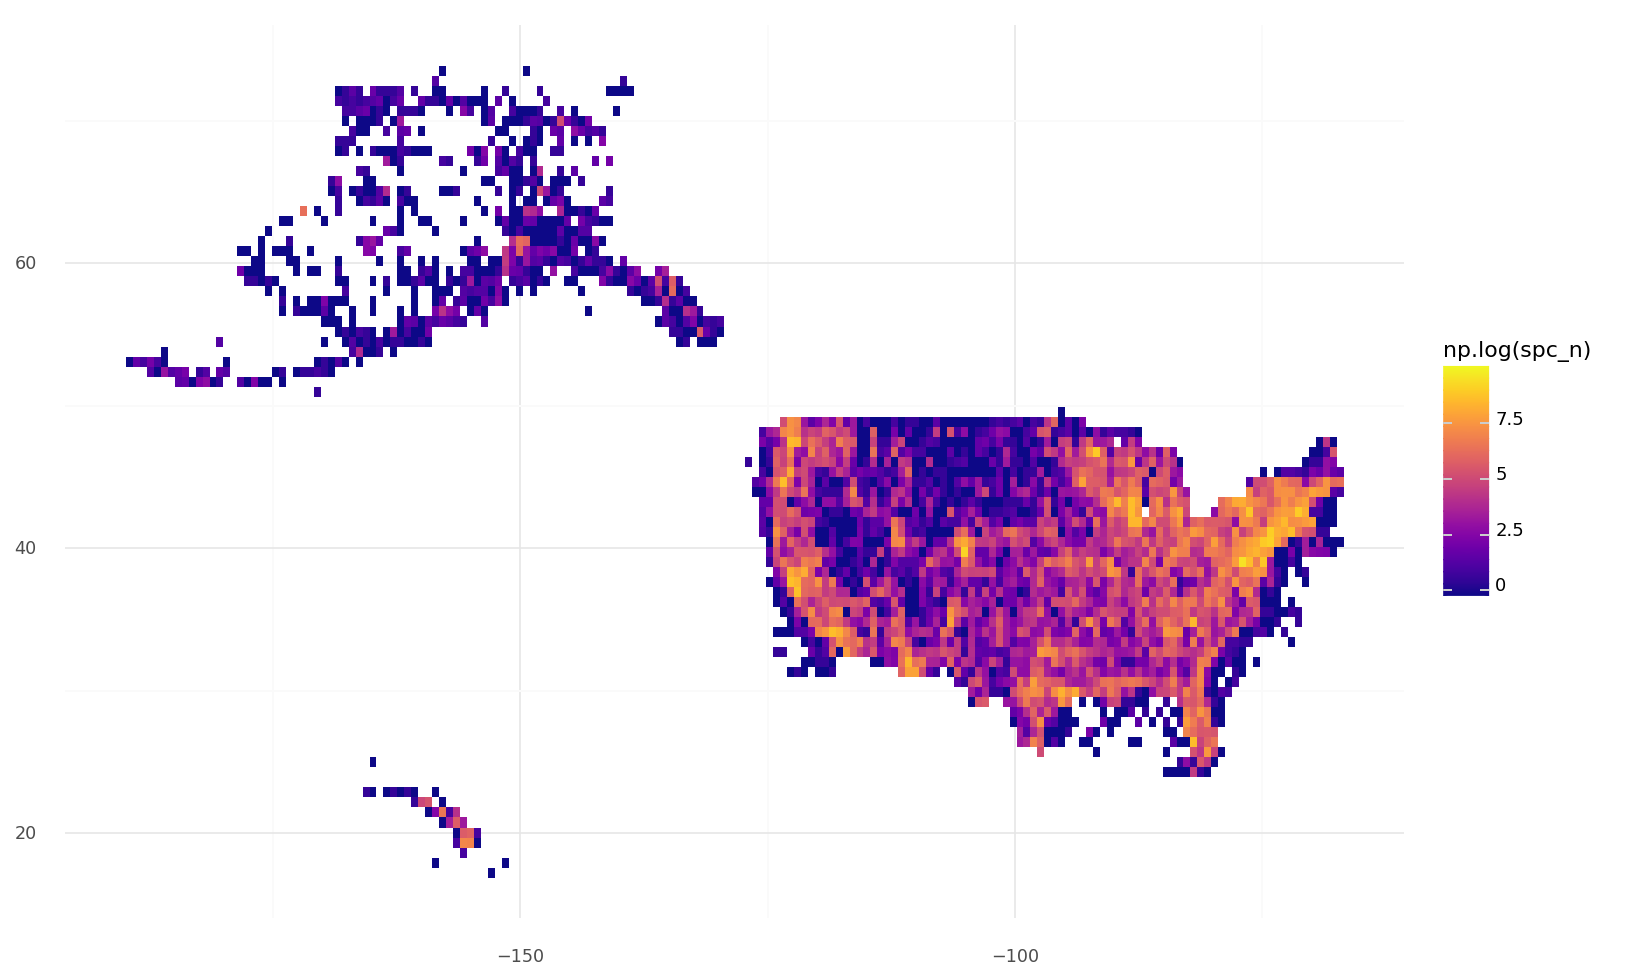

<ggplot: (310712868)>

In [ ]:
# Q: If ebd_US was truncated, did it truncate any dimensions we care about?
#   A: Nope: (loc, date) appears to have the expected coverage (maybe because the truncation was by checklist date?)
ebird_priors = EbirdPriors.load(
    # '3mi',  '4w', 1, ebd,  # pkl[g555k], load[ 66s]
    # '6mi',  '4w', 1, ebd,  # pkl[g332k], load[ 45s]
    # '12mi', '4w', 1, ebd,  # pkl[g168k], load[ 25s]
    # '24mi', '1w', 1, ebd,  # pkl[g203k], load[ 41s]
    # '24mi', '2w', 1, ebd,  # pkl[g120k], load[ 23s]
    # '24mi', '3w', 1, ebd,  # pkl[ g87k], load[ 18s]
    # '24mi', '4w', 1, ebd,  # pkl[ g69k], load[ 15s]
    # '24mi', '6w', 1, ebd,  # pkl[ g50k], load[ 12s]
    # '24mi', '8w', 1, ebd,  # pkl[ g39k], load[9.7s]
    '48mi', '6w', 1, ebd,  # pkl[ g16k], load[5.1s]
)
priors_keys = DF(
    columns=['loc_bin', 'date_bin', 'spc_n'],
    data=((loc_bin, date_bin, spc.n) for (loc_bin, date_bin), spc in ebird_priors.counts_.items()),
)
display(
    len(priors_keys),
    priors_keys[:3],
)
(priors_keys
    # [:1000]
    # .assign(n_date_bin=1).groupby('loc_bin')['n_date_bin'].sum().reset_index()
    .assign(
        w=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['w'])(df.loc_bin),
        e=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['e'])(df.loc_bin),
        s=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['s'])(df.loc_bin),
        n=lambda df: np.vectorize(otypes=[float], pyfunc=lambda x: ebird_priors.geoh_prec.str_bbox(x)['n'])(df.loc_bin),
    )
    .assign(**{
        # Adjust lon wrapping (in [-180,180])
        k: lambda df, k=k: (df[k] + 270) % 360 - 270
        for k in ['w', 'e']
    })
    .pipe(ggplot)
    # + aes(fill='factor(n_date_bin)') + scale_fill_cmap_d('plasma')  # For n_date_bin
    + aes(fill='np.log(spc_n)') + scale_fill_cmap('plasma')  # For spc_n
    + aes(xmin='w', xmax='e', ymin='s', ymax='n')
    + geom_bin2d(stat='identity')
    + theme_minimal()
    + theme_figsize(aspect=2/3)
)

In [ ]:
# Plot barcharts: priors[loc_bin==...][species, date_bin, p]
#   - TODO Port this from _counts_df:DF to ebird_priors.counts_:dict (so we can run it on any persisted model)
loc_bins = ebird_priors.loc_smooth(37.9, -122)  # Mt. Diablo ±1 (includes: SF, Berkeley hills, Mt Diablo, Marin)
(_counts_df
    [lambda df: df.loc_bin.isin(loc_bins)]
    .pipe(ebird_species_probs, groupby=['species', 'date_bin'], agg=['loc_bin'])
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .pipe(plot_barchart,
        # downsample_sp=30,  cols=1, width_per_col=4,    aspect_per_col=1.25,  # Good examle of 1 col
        # downsample_sp=30,  cols=3, width_per_col=14/3, aspect_per_col=0.278, # Great (better than 2 col)
        # downsample_sp=90,  cols=3, width_per_col=14/3, aspect_per_col=0.833, # Great (better than 2 col)
        # downsample_sp=170, cols=3, width_per_col=14/3, aspect_per_col=1.07,  # Great
        # downsample_sp=250, cols=4, width_per_col=5,    aspect_per_col=1.04,  # Great (width 18-22)
        # downsample_sp=300, cols=5, width_per_col=24/5, aspect_per_col=1.00,  # Great (almost full on sp)
        # downsample_sp=415, cols=6, width_per_col=4,    aspect_per_col=1.15,  # Good (room for more sp)
    )
)

[skip]

In [ ]:
# Plot species maps: priors[species==...][lat, lon, p]
#   - TODO Port this from _counts_df:DF to ebird_priors.counts_:dict (so we can run it on any persisted model)
species = ['WIWA']
(_counts_df
    [lambda df: df.species.isin(species)]
    .pipe(ebird_species_probs, groupby=['loc_bin'], agg=['species', 'date_bin'])
    .assign(
        w=lambda df: df.loc_bin.map(lambda x: ebird_priors.geoh_prec.str_bbox(x)['w']),
        e=lambda df: df.loc_bin.map(lambda x: ebird_priors.geoh_prec.str_bbox(x)['e']),
        s=lambda df: df.loc_bin.map(lambda x: ebird_priors.geoh_prec.str_bbox(x)['s']),
        n=lambda df: df.loc_bin.map(lambda x: ebird_priors.geoh_prec.str_bbox(x)['n']),
    )
    # .pipe(df_inspect, lambda df: (df.shape, df[:5]))
    .pipe(ggplot)
    + aes(fill='p', xmin='w', xmax='e', ymin='s', ymax='n')
    + geom_bin2d(stat='identity')
    + scale_fill_cmap('plasma')
    + theme_minimal()
    + theme_figsize('inline')
)

[skip]